In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from torch.amp import GradScaler
from torch.utils.data import Subset, DataLoader, TensorDataset
from torch.amp import autocast
from copy import deepcopy
import seaborn as sns

### Model parameters

In [2]:
# Hyperparameters
NUM_EPOCHS      = 1000
LEARNING_RATE   = 0.0001         

HIDDEN_SIZE     = 32            # Dimensionality of hidden units
NUM_FC_FEATURES = 128            # Number of output features, first FF layer
NUM_LSTM_LAYERS = 2             # Number of LSTM Layers

SEQ_LENGTH      = 60            # Length of inputs sequences
BATCH_SIZE      = 15

# Regular parameters
input_size  = 1      # Number of input features
output_size = 1      # Number of output features

criterion = nn.MSELoss()    # Set MSE as loss function

nr_folds = 10               # Number of folds in K-fold cross validation
kf = KFold(n_splits = nr_folds)

### Data Processing

In [3]:
# Get data
df = yf.download("BTC-USD", start="2017-1-1", end="2024-1-1", interval="1d")

# Get list of closing prices
closing_prices = list(df.iloc[:, 3])

[*********************100%%**********************]  1 of 1 completed


<Axes: ylabel='Density'>

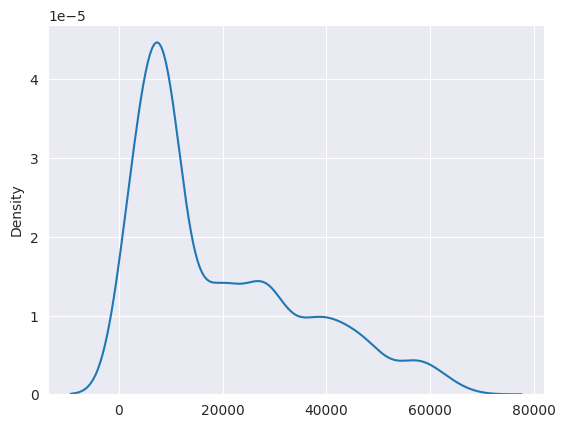

In [4]:
sns.set_style('darkgrid')
sns.kdeplot(np.array(closing_prices))

In [5]:
## Separate inputs (X) and labels (y)

def create_dataset(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])

    return np.array(X), np.array(y)

# Get list of closing prices
closing_prices = list(df.iloc[:, 3])

X, y = create_dataset(closing_prices, SEQ_LENGTH)

In [6]:
## Seperate training and test set

test_indices  = random.sample(range(len(X)), 300)
X_test = torch.tensor(X[test_indices], dtype=torch.float32)
y_test = torch.tensor(y[test_indices], dtype=torch.float32)

train_indices = [i for i in range(len(X)) if i not in test_indices]
X_train = torch.tensor(X[train_indices], dtype=torch.float32)
y_train = torch.tensor(y[train_indices], dtype=torch.float32)

# Reshape X,y into (nr_of_samples, seq_length, nr_of_features) -> necessary for LSTM
X_test = torch.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = torch.reshape(y_test, (y_test.shape[0], 1, 1))

X_train = torch.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = torch.reshape(y_train, (y_train.shape[0], 1, 1))

In [7]:
# Initialize scalers
# feature_scaler = MinMaxScaler()
# label_scaler = MinMaxScaler()

def normalize(X, y, input_scaler=MinMaxScaler(), output_scaler=MinMaxScaler(), fit=0):
    # Reshape training data to 2D for normalization
    X_reshaped = X.reshape(-1, X.shape[-1])  # shape: (nr_train_sequences * sequence_length, nr_of_features)
    y_reshaped = y.reshape(-1, y.shape[-1])  # shape: (nr_train_sequences * sequence_length, nr_of_features)

    if fit == 1:
        # Fit scaler to training data and transform training data
        X_normalized = input_scaler.fit_transform(X_reshaped)
        y_normalized = output_scaler.fit_transform(y_reshaped)
        
        if np.min(X_normalized) < 0: print(f'Value smaller than 0: {np.min(X_normalized)}')
        if np.max(X_normalized) > 1: print(f'Value greater than 1: {np.min(X_normalized)}')

    else:
        # Transform test data
        X_normalized = input_scaler.transform(X_reshaped)
        y_normalized = output_scaler.transform(y_reshaped)

    # if np.min(X_normalized) < 0: print(f'Value smaller than 0: {np.min(X_normalized)}')
    # if np.max(X_normalized) > 1: print(f'Value greater than 1: {np.min(X_normalized)}')

    # Reshape back to 3D
    X_normalized = X_normalized.reshape(X.shape)
    y_normalized = y_normalized.reshape(y.shape)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X_normalized, dtype=torch.float32)
    y_tensor = torch.tensor(y_normalized, dtype=torch.float32)

    return X_tensor, y_tensor, input_scaler, output_scaler

### LSTM model

In [8]:
# Set device to CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize gradscaler (AMP) -> gpu accelerations
# scaler = GradScaler()

/home/rdr/Documents/Trading_bot/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [9]:
class LSTM(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers, nr_fc_features):
        super(LSTM, self).__init__()

        self.hidden_size    = hidden_size
        self.num_layers     = num_layers

        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size, nr_fc_features)
        self.fc2 = nn.Linear(nr_fc_features, output_size)

        self.relu = nn.ReLU()

    def forward(self, X):
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device)

        output, (hn, cn) = self.lstm(X)

        # Only use the final hidden state of the final layer as input to the FF layers
        hn = hn[-1]

        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)

        return out

### Training and Testing

In [10]:
## Struct to store model info
class ModelInfo():
    def __init__(self):
        self.inputs     = []
        self.labels     = []
        self.outputs    = []
        self.loss       = float(0)
        self.model      = None
        self.train_loader  = None
        self.val_loader    = None
        self.input_scaler  = None
        self.output_scaler = None

# Store best model of every fold
results = {i:ModelInfo() for i in range(nr_folds)}
for i in range(nr_folds): results[i].loss = np.inf

----------
FOLD 0
epoch 0 | validation loss: 0.03248050039013227 | new best model!
epoch 1 | validation loss: 0.09686633894840876
epoch 2 | validation loss: 0.09958883921305338
epoch 3 | validation loss: 0.1015447199344635
epoch 4 | validation loss: 0.10149771521488825
epoch 5 | validation loss: 0.09455338964859644
epoch 6 | validation loss: 0.049145520230134326
epoch 7 | validation loss: 0.02351506135116021 | new best model!
epoch 8 | validation loss: 0.01483518114934365 | new best model!
epoch 9 | validation loss: 0.011258666031062603 | new best model!
epoch 10 | validation loss: 0.009010410277793805 | new best model!
epoch 11 | validation loss: 0.007482195133343339 | new best model!
epoch 12 | validation loss: 0.006347790779545903 | new best model!
epoch 13 | validation loss: 0.005515116282428304 | new best model!
epoch 14 | validation loss: 0.004876882691557209 | new best model!
epoch 15 | validation loss: 0.004421463717396061 | new best model!
epoch 16 | validation loss: 0.0040639

KeyboardInterrupt: 

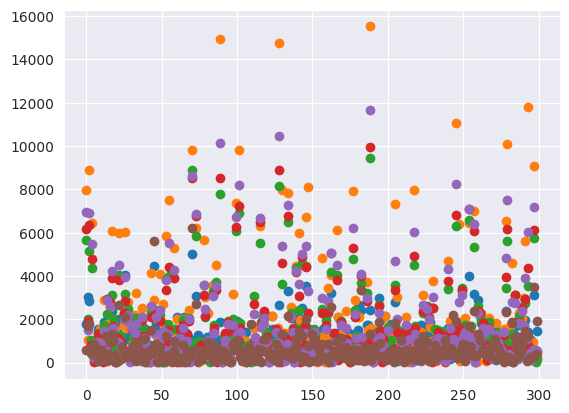

In [11]:
for fold, (train_indices, val_indices) in enumerate(kf.split(X_train)):
    print(f'----------\nFOLD {fold}')

    # Normalize Training and Validation sets
    X_train_fold, y_train_fold  = X_train[train_indices], y_train[train_indices]
    X_val_fold, y_val_fold      = X_train[val_indices], y_train[val_indices]

    X_train_fold, y_train_fold, in_scaler, out_scaler = normalize(X_train_fold, y_train_fold, fit=1)
    X_val_fold, y_val_fold, _, _                      = normalize(X_val_fold, y_val_fold, in_scaler, out_scaler, fit=0)

    results[fold].input_scaler  = in_scaler
    results[fold].output_scaler = out_scaler

    # Combine inputs and labels
    train_dataset_fold  = TensorDataset(X_train_fold, y_train_fold)
    val_dataset_fold    = TensorDataset(X_val_fold, y_val_fold)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset_fold, batch_size=BATCH_SIZE, 
                              shuffle=False, num_workers=1, pin_memory=True)
    val_loader   = DataLoader(val_dataset_fold, batch_size=BATCH_SIZE, 
                              shuffle=False, num_workers=1, pin_memory=True)

    # Create LSTM object and move it to the GPU
    lstm = LSTM(output_size, input_size, HIDDEN_SIZE, NUM_LSTM_LAYERS, NUM_FC_FEATURES).to(device)

    # Initialize optimizer
    optimizer = torch.optim.Adam(lstm.parameters(), lr=LEARNING_RATE)

    epochs_wo_improvement = 0
    for epoch in range(NUM_EPOCHS):
        if epochs_wo_improvement > 50:
            print('early stopping!')
            break

        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            targets = targets.reshape(targets.shape[0],1)

            inputs  = inputs.to(device)
            targets = targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = lstm.forward(inputs)
            # Compute loss
            loss = criterion(outputs, targets)
            # Backward pass
            loss.backward()
            # Parameter update
            optimizer.step()

        val_results = ModelInfo()
        val_results.loss = 0 
        val_results.model = deepcopy(lstm.state_dict())
        with torch.no_grad():
            for i, val_data in enumerate(val_loader, 0):
                val_inputs, val_targets = val_data
                val_targets = val_targets.reshape(val_targets.shape[0], 1)

                val_inputs  = val_inputs.to(device)
                val_targets = val_targets.to(device)

                val_outputs = lstm.forward(val_inputs)
                val_loss = criterion(val_outputs, val_targets)

                for i in range(val_inputs.shape[0]):
                    single_input = val_inputs[i].flatten()
                    single_label = val_targets[i]
                    single_output = val_outputs[i]

                    val_results.inputs.append(single_input)
                    val_results.labels.append(single_label)
                    val_results.outputs.append(single_output)

                val_results.loss += float(val_loss.item())
        val_results.loss /= len(val_loader)

        if results[fold].loss > val_results.loss:
            val_results.train_loader  = deepcopy(train_loader)
            val_results.val_loader    = deepcopy(val_loader)
            val_results.input_scaler  = deepcopy(results[fold].input_scaler)
            val_results.output_scaler = deepcopy(results[fold].output_scaler)
            results[fold]             = deepcopy(val_results)

            print(f'epoch {epoch} | validation loss: {val_results.loss} | new best model!')
            epochs_wo_improvement = 0
        else:
            print(f'epoch {epoch} | validation loss: {val_results.loss}')
            epochs_wo_improvement += 1

    X_test_norm, y_test_norm, _, _ = normalize(X_test, y_test, results[fold].input_scaler, results[fold].output_scaler, fit=0)
    
    lstm_test = LSTM(output_size, input_size, HIDDEN_SIZE, NUM_LSTM_LAYERS, NUM_FC_FEATURES).to(device)

    lstm_test.load_state_dict(results[fold].model)

    # Set the model to evaluation mode
    lstm_test.eval()

    X_test_norm = X_test_norm.to(device)
    test_output = lstm_test.forward(X_test_norm).to(device)

    test_output_np = test_output.cpu().data.numpy()
    test_labels_np = y_test_norm.data.numpy()
    test_labels_np = test_labels_np.reshape(test_labels_np.shape[0], 1)

    X_plot = results[fold].input_scaler.inverse_transform(test_output_np)
    y_plot = results[fold].output_scaler.inverse_transform(test_labels_np)

    errors = np.abs(X_plot - y_plot)
    avg_error = np.mean(errors)
    print(f'Average test error: {avg_error}\n')

    plt.scatter(np.arange(len(errors)), errors)



----

In [ ]:
nr_folds = 10               # Number of folds in K-fold cross validation
kf = KFold(n_splits = nr_folds)

for fold, (train_indices, val_indices) in enumerate(kf.split(X_train)):
    # Normalize Training and Validation sets
    X_train_fold, y_train_fold  = X_train[train_indices], y_train[train_indices]
    X_val_fold, y_val_fold      = X_train[val_indices], y_train[val_indices]

    X_train_fold, y_train_fold = normalize(X_train_fold, y_train_fold, fit=1)
    X_val_fold, y_val_fold     = normalize(X_val_fold, y_val_fold, fit=0)



Value smaller than 0: -0.03690612662642104
